In [1]:
#------------------------------------------------------------------------------------------------------------------------------------------
# basic setup of the notebook
#------------------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import numba as nb
from numba import njit, prange
from numba.experimental import jitclass
import sys

import tomllib
from pip._vendor import tomli
import sys, os
from joblib import Parallel, delayed
import multiprocess as mp
from concurrent.futures import ProcessPoolExecutor
import scipy as sp
from scipy import *
import faulthandler
faulthandler.enable()

sys.path.append('../code')
from fit_drivers import *
from minimizer import *
from fit_functions import *
from output_functions import *
from general_stats import *
from jpac_colors import *
import fit_drivers, minimizer, fit_functions, output_functions, general_stats 

import math
import timeit
import time

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit import minimize
import time
from iminuit.util import describe
from typing import Annotated

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

iminuit version: 2.30.1


In [2]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis
#------------------------------------------------------------------------------------------------------------------------------------------
lattice_sizes=[20,24,28,32]

f_data_ratios=[]
f_data_ratios_err=[]
for l in range(len(lattice_sizes)):

    xirun=[]
    betarun=[]
    betax=[]

    file=['../ini_files/W_analysis_L{}_xi=1_pole.toml'.format(lattice_sizes[l]),'../ini_files/W_analysis_L{}_xi=1.toml'.format(lattice_sizes[l])]
    file_basic=['../ini_files/basic_setup_pole.toml','../ini_files/basic_setup.toml']

    data_f=[]
    edata_f=[]
    for x in range(len(file)):
        with open("{}".format(file[x]), "rb") as f:
            params = tomli.load(f)

        with open("{}".format(file_basic[x]), "rb") as f2:
            params2 = tomli.load(f2)

        for i in params:
            params['{}'.format(i)].update(params2['{}'.format(i)])


        who            = params['creator']['who']


        path           = params['paths_to_files']['base_path']
        mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
        resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
        resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
        plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
        Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
        sizelabel      = params['paths_to_files']['sizelabel']      


        corrtype       = params['correlators']['corrtype']
        xi             = params['correlators']['xi']
        beta           = params['correlators']['beta']
        betanorm       = params['correlators']['betanorm']
        Lextent        = params['correlators']['Lextent']
        Textent        = params['correlators']['Textent']
        size           = params['correlators']['size']
        Ncfgs          = params['correlators']['Ncfgs']


        dini_Gc        = params['minimization_parameters']['dini_Gc']
        dstop_Gc       = params['minimization_parameters']['dstop_Gc']
        dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
        dini_Vr        = params['minimization_parameters']['dini_Vr']
        dstop_Vr       = params['minimization_parameters']['dstop_Vr']
        dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
        dfin_Gc        = params['minimization_parameters']['dfin_Gc']
        dfin_Vr        = params['minimization_parameters']['dfin_Vr']
        reuse          = params['minimization_parameters']['reuse']
        inv_first      = params['minimization_parameters']['inv_first']
        mcalls         = params['minimization_parameters']['mcalls']
        mtol           = params['minimization_parameters']['mtol']
        inipars_Gc     = params['minimization_parameters']['inipars_GC']
        variants_Gc    = params['minimization_parameters']['variants_GC']
        jackkl         = params['minimization_parameters']['jackkl']
        xiini          = params['minimization_parameters']['xiini']
        xifin          = params['minimization_parameters']['xifin']   
        fileini        = params['minimization_parameters']['fileini']                         
        filefin        = params['minimization_parameters']['filefin']
        datatype_Gc    = params['minimization_parameters']['datatype_Gc']
        model_Gc       = params['minimization_parameters']['model_Gc']
        model_Vr       = params['minimization_parameters']['model_Vr']
        datatype_Vr    = params['minimization_parameters']['datatype_Vr']
        inipars_Vr     = params['minimization_parameters']['inipars_Vr']
        variants_Vr    = params['minimization_parameters']['variants_Vr']
        multiprocess   = params['minimization_parameters']['multiprocess']
        improve        = params['minimization_parameters']['improve']
        multistart     = params['minimization_parameters']['multistart']   
        cov_freeze     = params['minimization_parameters']['cov_freeze'] 

        clean          = params['extra']['clean']
        cutoff_ma      = params['extra']['cutoff_ma']
        no_corrs       = params['extra']['no_corrs']
        no_valid_check = params['extra']['no_valid_check']

        als            = params['correlators']['als']

        signorm=0.44**2
           # Copy pasted from Sebastian's slack table (they do not correspond to this lattices!! It is just a sloppy calc)

        xifin=3
        filefin=7

        xirun.append(xi[xiini:xifin+1])
        betarun.append(beta[fileini:filefin+1])


        # Data used in the analysis
        data_int=[]
        edata_int=[]    
        alsx=[]
        betax.append(np.array(betarun[x])/betanorm)
        for k in range(len(xi)):
            data_int_int=[]
            edata_int_int=[]
            for j in range(len(betarun[x])):
                alsx.append(als[k][j])
                data_int_int.append(np.loadtxt('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))[0]*xi[k]/als[k][j]**2)
                edata_int_int.append(np.loadtxt('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))[1]*xi[k]/als[k][j]**2)
            data_int.append(data_int_int)
            edata_int.append(edata_int_int)
            
        data_f.append(data_int)
        edata_f.append(edata_int)
    
    xilen=len(xirun[0])
    betalen=len(betarun[0])
    
    
    data_ratios     = []
    data_ratios_err = []

    for k in range(xilen):
        data_ratios_int     = []
        data_ratios_err_int = []
        for j in range(betalen):
            avg_Coulomb=data_f[0][k][j]
            avg_Wilson=data_f[1][0][j]
            data_ratios_int.append(avg_Coulomb/avg_Wilson)
            err_Coul=edata_f[0][k][j]
            err_Wilson=edata_f[1][0][j]
            data_ratios_err_int.append(np.sqrt((err_Coul/avg_Wilson)**2+(avg_Coulomb/avg_Wilson**2*err_Wilson)**2))
            
        data_ratios.append(data_ratios_int)  
        data_ratios_err.append(data_ratios_err_int)

    f_data_ratios.append(data_ratios)
    f_data_ratios_err.append(data_ratios_err)

gevmtofm=5.068

In [84]:
# Fixed volume analysis, start by colecting lattices with similar total volumes

index_selected=[[[[0,0,0],[1,0,0],[2,0,0],[3,0,0]]]]
#[[[[0,0,6],[2,0,4]],[[0,1,7],[2,1,5]],[[0,2,7],[2,2,5]],[[0,3,7],[2,3,5]]],[[[1,0,7],[0,0,5],[2,0,3]],[[0,1,6],[2,1,4]],[[0,2,6],[2,2,4]],[[0,3,6],[2,3,4]]],[[[1,0,6],[0,0,4],[2,0,2]],[[1,1,7],[0,1,5],[2,1,3]],[[1,2,7],[0,2,5],[2,2,3]],[[1,3,7],[0,3,5],[2,3,3]]],[[[1,0,5],[0,0,3],[2,0,1]],[[1,1,6],[0,1,4],[2,1,2]],[[1,2,6],[0,2,4],[2,2,2]],[[1,3,6],[0,3,4],[2,3,2]]],[[[1,0,4],[0,0,2],[2,0,0]],[[1,1,5],[0,1,3]],[[1,2,5],[0,2,3],[2,2,1]],[[1,3,5],[0,3,3],[2,3,1]]],[[[1,0,3],[0,0,1]],[[1,1,4],[0,1,2]],[[1,2,4],[0,2,2]],[[1,3,4],[0,3,2],[2,3,0]]],[[[1,0,2],[0,0,0]],[[1,1,3],[0,1,1]],[[1,2,3],[0,2,1]],[[1,3,3],[0,3,1]]]]#,[[[0,0,5],[1,0,7]],[[0,1,6],[1,1,8]]]]

data_a_t       = []
data_V_t       = []
data_V_t_err   = []
data_sigma     = []
data_sigma_err = []
for index_vol in index_selected:
    data_V_t_int   = []
    data_a_t_int   = []
    data_sigma_int = []
    data_sigma_err_int = []
    for index_xi in index_vol:
        data_a_t_int_int   = []
        data_sigma_int_int = []
        data_sigma_err_int_int = []
        for index_l in index_xi:
            data_a_t_int_int.append(als[index_l[1]][index_l[0]])
            data_V_t_int.append(als[index_l[1]][index_l[0]]*lattice_sizes[index_l[0]])
            data_sigma_int_int.append(f_data_ratios[index_l[0]][index_l[1]][index_l[2]])
            data_sigma_err_int_int.append(f_data_ratios_err[index_l[0]][index_l[1]][index_l[2]])
        
        data_sigma_int_int=[data_sigma_int_int[i] for i in np.argsort(data_a_t_int_int)]
        data_sigma_err_int_int=[data_sigma_err_int_int[i] for i in np.argsort(data_a_t_int_int)]
        data_sigma_err_int.append(data_sigma_err_int_int)
        data_sigma_int.append(data_sigma_int_int)
        data_a_t_int_int.sort()
        data_a_t_int.append(data_a_t_int_int)

    data_a_t.append(data_a_t_int)
    data_sigma.append(data_sigma_int)
    data_sigma_err.append(data_sigma_err_int)
    print(data_V_t_int)
    data_V_t.append(np.mean(data_V_t_int))
    data_V_t_err.append(np.sqrt(np.var(data_V_t_int)))

#data_a_t=np.array(data_a_t,dtype=object)
#data_sigma=np.array(data_sigma,dtype=object)
#data_sigma_err=np.array(data_sigma_err,dtype=object)
data_x_V=np.array(data_V_t)
data_x_err_V=np.array(data_V_t_err)


[1.55341, 1.5558576, 1.5569568, 1.5587136]


In [96]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Defining Minuit Classes
#------------------------------------------------------------------------------------------------------------------------------------------
class Mod_LeastSquares:
    """
    Generic least-squares cost function
    """

    errordef = Minuit.LEAST_SQUARES  # for Minuit to compute errors correctly

    def __init__(self, model, x, y, yerr):
        self.model = eval(model)  # model predicts y for given x
        self.x = x
        self.y = y
        self.yerr = yerr
    
    @property
    def ndata(self):
        if isinstance(self.y, list):
            nfdata=0
            for k in range(len(self.y)):
                nfdata+=len(self.x[k])
        else:
            nfdata=len(self.x)
        return nfdata

    def __call__(self, par):  # we must accept a variable number of model parameters

        if isinstance(self.y, list):
            ym=[]
            fun=[]
            for k in range(len(self.y)):
                if (len(par)>1):
                    parf=[par[0],par[k+1]]                        # par[0] (extrapolation to a=0) is common for all fits
                else:
                    parf=[par[0]]

                ym.append(self.model(self.x[k], *parf))
                fun.append(np.dot((self.y[k] - ym[k])/self.yerr[k],(self.y[k] - ym[k])/self.yerr[k]))
            fun=np.sum(np.array(fun))
        else:
            ym  = self.model(self.x, par)
            fun = np.dot((self.y - ym)/self.yerr,(self.y - ym)/self.yerr)

        return fun
        
class BetterLeastSquares(LeastSquares):

    def __init__(self, model, x, y, yerr):
        super().__init__(model, x, y, yerr)
        pars = describe(model, annotations=True)
        model_args = iter(pars)
        next(model_args)
        _parameters = {k: pars[k] for k in model_args}


class EvenBetterLeastSquares(BetterLeastSquares):
    @property
    def ndata(self):
        return len(self.x)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.082 (χ²/ndof = 0.5)      │              Nfcn = 60               │
│ EDM = 7.02e-24 (Goal: 2e-07)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.61    │   0.34    │            │            │         │         │       │
│ 1 │ x1   │  0.23e3   │  0.12e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────┐
│    │      x0      x1 │
├────┼─────────────────┤
│ x0 │   0.114  -38.95 │
│ x1 │  -38.95 1.4e+04 │
└────┴─────────────────┘

<Figure size 1600x900 with 0 Axes>

/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_59874/426273071.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(data_x_a[k], data_sigma_a[k], data_sigma_err_a[k], fmt="ok", alpha=0.8,color=jpac_color_around[k],label='$\\xi={}$'.format(k+1))


<ErrorbarContainer object of 3 artists>

Text(0.2, 0.4, '$L=1.56\\pm0.00$')

Text(0.2, 0.3, '$\\sigma_C/\\sigma_W=0.61\\pm0.34$')

Text(0.2, 0.2, '$\\chi^2/ndof=0.5$')

Text(0, 1, '$\\sigma_R$')

Text(0.5, 0, '$a_s$ (fm)')

(0.0, 0.1)

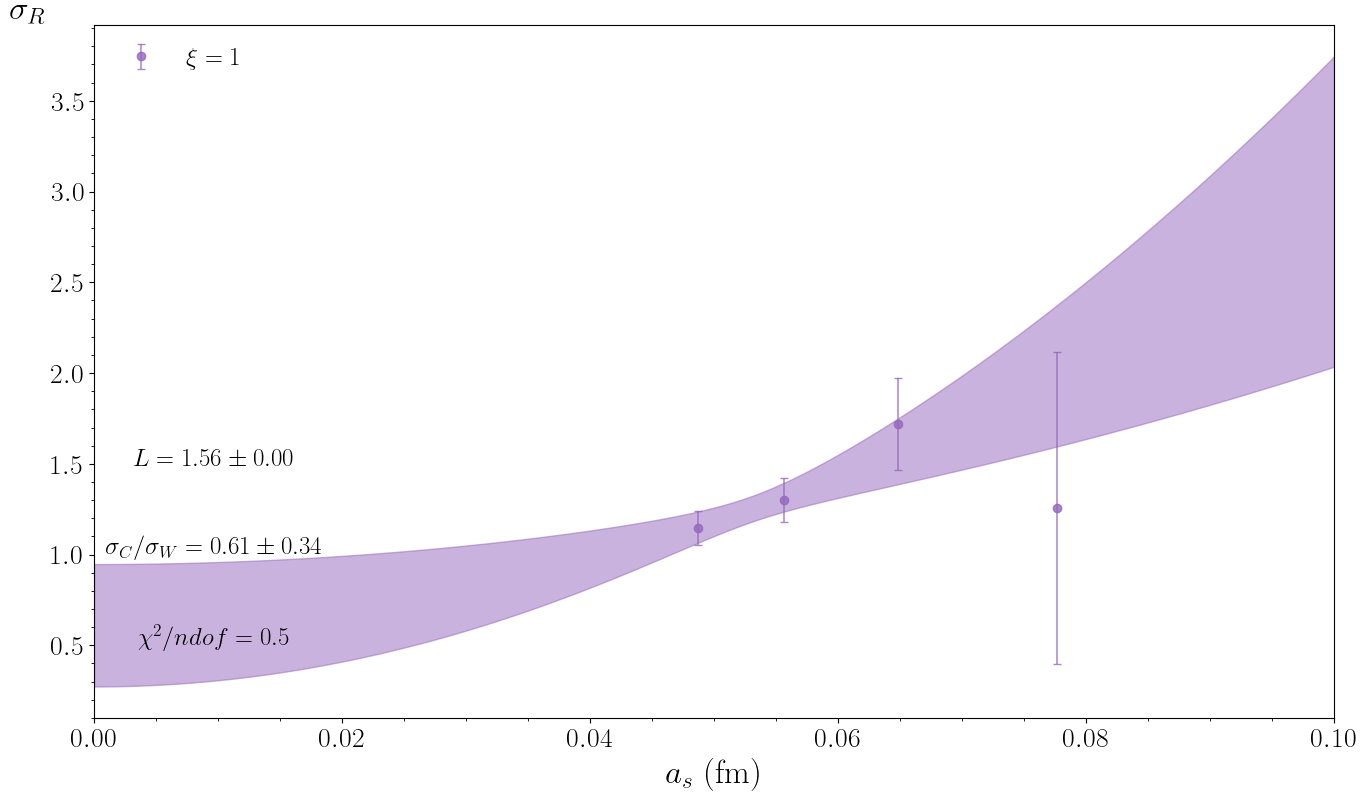

In [121]:
# Perform a fit to the a dependence on a "fixed" volume


chi_ndof       = []
ratio_list     = []
ratio_err_list = []

for index_vol in range(len(data_a_t)):
    data_x_a=data_a_t[index_vol]
    data_sigma_a=data_sigma[index_vol]
    data_sigma_err_a=data_sigma_err[index_vol]

    model='line_np_mod'
    ini_pars=[1,1]

    mod_least_squares = Mod_LeastSquares(model, data_x_a, data_sigma_a, data_sigma_err_a)

    m = Minuit(mod_least_squares,ini_pars)  
    m.tol=mtol
    m.migrad(mcalls).migrad(mcalls).hesse()

    fit_vals    = np.array(m.values)
    fit_errors  = np.array(m.errors)
    fit_corrs   = np.array(m.covariance.correlation())

    chi_ndof.append(m.fval/m.ndof) 
    ratio_list.append(fit_vals[0])
    ratio_err_list.append(fit_errors[0])#*np.sqrt(m.fval))

    data_x_plot   = np.linspace(0,0.1,1000)
    plt.figure(figsize=(16,9))
    for k in range(len(data_x_a)):
        if (len(fit_vals)>1):
            plot_vals   = np.append(fit_vals[0],fit_vals[k+1])
            plot_errs   = np.append(fit_errors[0],fit_errors[k+1])
            plot_corrs  = fit_corrs[np.ix_([0,k+1],[0,k+1])]
        else:
            plot_vals   = np.array([fit_vals[0]])
            plot_errs   = np.array([fit_errors[0]])
            plot_corrs  = fit_corrs[0,0]      

        fit_line    = eval(model)(data_x_plot,*plot_vals)
        fit_err_band= prop_err(data_x_plot,model,plot_vals,plot_errs,plot_corrs)

        plt.errorbar(data_x_a[k], data_sigma_a[k], data_sigma_err_a[k], fmt="ok", alpha=0.8,color=jpac_color_around[k],label='$\\xi={}$'.format(k+1))
        plt.fill_between(data_x_plot, fit_line+fit_err_band, fit_line-fit_err_band,color=jpac_color_around[k],alpha=0.5)

    plt.figtext(0.2, 0.4, 
    '$L={:.2f}\\pm{:.2f}$'.format(data_x_V[index_vol],data_x_err_V[index_vol]), 
    horizontalalignment ="center",  
    verticalalignment ="center",  
    wrap = True, fontsize = 18,  
    color ="black")

    plt.figtext(0.2, 0.3, 
    '$\\sigma_C/\\sigma_W={:.2f}\\pm{:.2f}$'.format(fit_vals[0],fit_errors[0]), 
    horizontalalignment ="center",  
    verticalalignment ="center",  
    wrap = True, fontsize = 18,  
    color ="black")

    plt.figtext(0.2, 0.2, 
    '$\\chi^2/ndof={:.1f}$'.format(chi_ndof[index_vol]), 
    horizontalalignment ="center",  
    verticalalignment ="center",  
    wrap = True, fontsize = 18,  
    color ="black")

    plt.legend(fontsize=18,frameon=False,loc=0)
    plt.ylabel('$\\sigma_R$',fontsize=24,rotation=0,loc='top')
    plt.xlabel("$a_s$ (fm)",fontsize=24)
    plt.xlim(0,0.1)
    plt.show()

In [14]:

model='line_np_mod'
ini_pars=[2]

mod_least_squares = Mod_LeastSquares(model, data_x_V, np.array(ratio_list), np.array(ratio_err_list))

plt.figure(figsize=(16,9))

m = Minuit(mod_least_squares,ini_pars)  
m.tol=mtol
m.migrad(mcalls).migrad(mcalls).hesse()
fit_vals    = np.array(m.values)
fit_errors  = np.array(m.errors)
fit_corrs   = np.array(m.covariance.correlation())

final_chi2_ndof=m.fval/m.ndof

data_x_plot=np.linspace(0,10,1000)

fit_line    = eval(model)(data_x_plot,*fit_vals)
fit_err_band= prop_err(data_x_plot,model,fit_vals,fit_errors,fit_corrs)

plt.errorbar(data_x_V,ratio_list,ratio_err_list,data_x_err_V, fmt="ok", alpha=1,color=jpac_color_around[0])
plt.fill_between(data_x_plot, fit_line+fit_err_band, fit_line-fit_err_band,color=jpac_color_around[0],alpha=0.5)


plt.figtext(0.15, 0.85, 
    '$\\sigma_C/\\sigma_W={:.2f}\\pm{:.2f},\,\\chi^2/ndof={:.1f}$'.format(fit_vals[0],fit_errors[0],final_chi2_ndof), 
    horizontalalignment ="left",  
    verticalalignment ="center",  
    wrap = True, fontsize = 18,  
    color ="black")
for index_vol in range(len(chi_ndof)):
    plt.figtext(0.15, 0.3-0.04*index_vol, 
        '$\\chi^2/ndof={:.1f},\,L={:.1f}$'.format(chi_ndof[index_vol],data_x_V[index_vol]), 
        horizontalalignment ="left",  
        verticalalignment ="center",  
        wrap = True, fontsize = 18,  
        color ="black")

plt.legend(fontsize=18,frameon=False,loc=0)
plt.ylabel('$\\sigma_R$',fontsize=24,rotation=0,loc='top')
plt.xlabel("$L$ (fm)",fontsize=24)
plt.xlim(1.8,5.)
plt.show()

<>:27: SyntaxWarning: invalid escape sequence '\,'
<>:34: SyntaxWarning: invalid escape sequence '\,'
<>:27: SyntaxWarning: invalid escape sequence '\,'
<>:34: SyntaxWarning: invalid escape sequence '\,'
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_57013/1415033843.py:27: SyntaxWarning: invalid escape sequence '\,'
  '$\\sigma_C/\\sigma_W={:.2f}\\pm{:.2f},\,\\chi^2/ndof={:.1f}$'.format(fit_vals[0],fit_errors[0],final_chi2_ndof),
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_57013/1415033843.py:34: SyntaxWarning: invalid escape sequence '\,'
  '$\\chi^2/ndof={:.1f},\,L={:.1f}$'.format(chi_ndof[index_vol],data_x_V[index_vol]),


<Figure size 1600x900 with 0 Axes>

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 443              │
│ EDM = nan (Goal: 2e-07)          │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     2     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_57013/1415033843.py:27: SyntaxWarning: invalid escape sequence '\,'
  '$\\sigma_C/\\sigma_W={:.2f}\\pm{:.2f},\,\\chi^2/ndof={:.1f}$'.format(fit_vals[0],fit_errors[0],final_chi2_ndof),
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_57013/1415033843.py:34: SyntaxWarning: invalid escape sequence '\,'
  '$\\chi^2/ndof={:.1f},\,L={:.1f}$'.format(chi_ndof[index_vol],data_x_V[index_vol]),


AttributeError: 'NoneType' object has no attribute 'correlation'

<Figure size 1600x900 with 0 Axes>

In [16]:

# Find out similar total volumes
als=np.array(als)[:3,:8]
lattice_sizes=[24,32]

def total_volumes(sizes,spacings):
    list_total_volumes=[]
    for i in sizes:
        list_total_volumes_int=[]
        for j in range(len(spacings)):
            list_total_volumes_int_int=[]
            for val in spacings[j]:
                list_total_volumes_int_int.append(i*val)
            list_total_volumes_int.append(list_total_volumes_int_int)
        list_total_volumes.append(list_total_volumes_int)
    list_total_volumes=np.array(list_total_volumes)

    return list_total_volumes


def find_similar_volumes(list,deviation):    # Find lattices with same total volume within and accepted/provided deviation in percentage
    labels=[]
    for xi in range(len(list)):
        for L in range(len(list[xi])):
            for k in range(len(list[xi][L])):
                diff_list=np.abs((list-list[xi][L][k]))
                where=np.where(diff_list<deviation)
                if len(where[0])>1:
                    labels.append(where)
    return np.array(labels,dtype=object)


a=total_volumes(lattice_sizes,als)
indexes=find_similar_volumes(a,0.5)